In [2]:
import spacy
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Cargar modelo en español de spaCy
nlp = spacy.load("es_core_news_sm")

# Lista de palabras clave
keywords = ['lluvia', 'inundación', 'accidente', 'apagón', 'deslave', 'desborde', 'incendio', 'fuga', 'colapso']

# Función para eliminar los símbolos, emoticones y links
def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F700-\U0001F77F"  
        u"\U0001F780-\U0001F7FF"  
        u"\U0001F800-\U0001F8FF"  
        u"\U0001F900-\U0001F9FF"  
        u"\U0001FA00-\U0001FA6F"  
        u"\U0001FA70-\U0001FAFF"  
        u"\U00002700-\U000027BF"  
        u"\U0001F1E0-\U0001F1FF"  
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Función para verificar si el tweet contiene una palabra clave o sus variantes
def contains_keyword(text, keywords, nlp):
    doc = nlp(text)
    lemmas = {token.lemma_ for token in doc}
    return any(keyword in lemmas for keyword in keywords)

# Cargar la base de datos
tweets_file = "tweets_Jun20.csv"
df_tweets = pd.read_csv(tweets_file)

# Eliminar tweets que no tienen texto
df_tweets_clean = df_tweets.dropna(subset=['Texto'])

# Aplicar la función de limpieza a la columna de texto
df_tweets_clean['Texto'] = df_tweets_clean['Texto'].apply(clean_text)

# Filtrar los tweets que contienen una palabra clave o sus variantes
df_tweets_filtered = df_tweets_clean[df_tweets_clean['Texto'].apply(lambda x: contains_keyword(x, keywords, nlp))]

# Guardar el resultado filtrado
df_tweets_filtered.to_csv('tweets_filtered.csv', index=False)


/Users/Daniel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_16658/1871256833.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_clean['Texto'] = df_tweets_clean['Texto'].apply(clean_text)


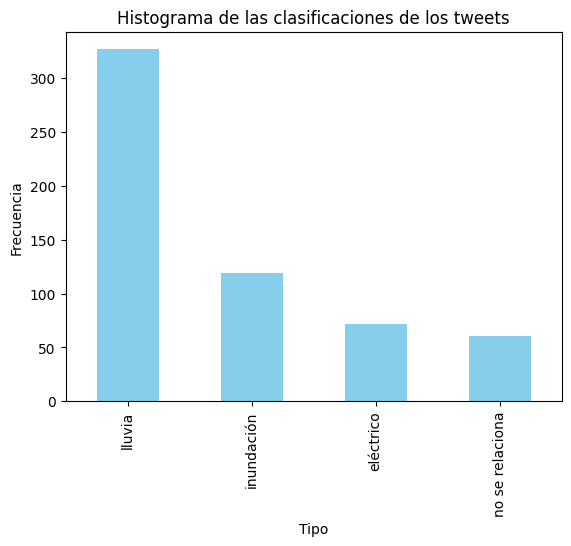

In [3]:
tweets_clean_classified = "tweets_better_classified.csv"
df_tweets_clean_fil = pd.read_csv(tweets_clean_classified)

tipo_counts = df_tweets_clean_fil['Tipo'].value_counts()

# Creación del histograma
tipo_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')
plt.title('Histograma de las clasificaciones de los tweets')
plt.show()

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# Cargar el dataset
df = pd.read_csv("tweets_better_classified.csv")

# Preprocesar las etiquetas
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Tipo'])  # Ajusta 'categoria' a la columna correspondiente

# Dividir el dataset en entrenamiento y prueba
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Inicializar el tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Función para tokenizar los textos
def tokenize_function(examples):
    return tokenizer(examples['Texto'], padding="max_length", truncation=True, max_length=128)

# Aplicar el tokenizer a los datos de entrenamiento y prueba
train_encodings = tokenizer(list(train['Texto'].values), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test['Texto'].values), truncation=True, padding=True, max_length=128)

# Convertir las etiquetas en tensores
train_labels = torch.tensor(train['label'].values)
test_labels = torch.tensor(test['label'].values)

# Crear un dataset personalizado
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

# Cargar el modelo BERT para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)  # Ajusta num_labels al número de clases

# Definir los argumentos del entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio para guardar los resultados
    num_train_epochs=2,              # Número de épocas
    per_device_train_batch_size=16,  # Tamaño del lote en entrenamiento
    per_device_eval_batch_size=64,   # Tamaño del lote en evaluación
    warmup_steps=500,                # Número de pasos para warmup
    weight_decay=0.01,               # Tasa de decaimiento del peso
    logging_dir='./logs',            # Directorio para guardar los logs
    logging_steps=10,
)

# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Reporte de clasificación
print(classification_report(test_labels, preds, target_names=label_encoder.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [20]:
pip install transformers[torch]


zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.
